<a href="https://colab.research.google.com/github/acumenmanish/ImageRestoration/blob/master/RestoreImage_with_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kaggle

In [2]:
# select file containing API key from local system
# from google.colab import files
# uploaded = files.upload()

In [3]:
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/

In [4]:
# !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d hsankesara/flickr-image-dataset

In [6]:
import zipfile
import shutil
from PIL import Image
import numpy as np
import os
from random import sample

In [7]:
zip_file = zipfile.ZipFile('/content/flickr-image-dataset.zip', 'r')

In [8]:
image_files = [filename for filename in zip_file.namelist() if filename.endswith('.jpg') or filename.endswith('.png')]

In [9]:
image_files[0]

'flickr30k_images/flickr30k_images/1000092795.jpg'

In [10]:
images = []
for image_file in image_files[0:10000]:
    with zip_file.open(image_file) as f:
        with Image.open(f) as img:
          img = img.resize((128, 128))
          images.append(np.array(img, dtype='float32')/255.0)

In [11]:
# img_arr = []
# image_dir = '/content/drive/MyDrive/Input Data/images/'
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
# for image_file in image_files:
#   with PIL.Image.open(image_file) as img:
#       if img.mode =='RGB':
#         img = img.resize((128, 128))
#         img_arr.append(np.array(img, dtype="float32") / 255.0)


In [12]:

image_array = np.array(list(filter(lambda x: x is not None ,images)))

In [13]:
zip_file.close()

In [14]:

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(image_array, test_size=0.2, random_state=40)

In [15]:

# adding noise to the training images 
noise_factor = 0.2
X_train_noisy = train_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)  
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

In [16]:

# adding noise to the training images 
noise_factor = 0.2
X_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)  
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [17]:
from tensorflow import keras
from keras import layers

class ConvAutoencoder:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.encoder = None
        self.decoder = None
        self.autoencoder = None


    def build_encoder(self):
        input_img = keras.Input(shape=self.input_shape)

        # Encoder Layers
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2), strides = (2,2), padding='same')(x)
        # x = layers.add(Dropout(0.25))(x) # adding a dropout layer after the max pooling layer
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2), strides = (2,2), padding='same')(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)        
        encoded = layers.MaxPooling2D((2, 2), strides = (2,2), padding='same')(x)

        self.encoder = keras.Model(input_img, encoded)
        self.encoder.summary()
        return encoded.shape[1:]

    def build_decoder(self, inputShape):
        # Decoder Layers
        encoded_input = keras.Input(shape=inputShape)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_input)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.BatchNormalization()(x)
        decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        self.decoder = keras.Model(encoded_input, decoded)
        self.decoder.summary()

    def build_autoencoder(self):
        input_img = keras.Input(shape=self.input_shape)
        encoded = self.encoder(input_img)
        decoded = self.decoder(encoded)
        self.autoencoder = keras.Model(input_img, decoded)
        self.autoencoder.summary()

        self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    def train(self, train_noisy, train,test_noisy, test, epochs, batch_size,callbacks):
        return self.autoencoder.fit(train_noisy,train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             callbacks=callbacks,
                             validation_data=(test_noisy, test))

    def restore(self, x):
        restored_imgs = self.autoencoder.predict(x)
        return restored_imgs

In [18]:
# Initialize the Convolutional Autoencoder
autoencoder = ConvAutoencoder(input_shape=train_data.shape[1:])

# Build the encoder, decoder and autoencoder
outputShape = autoencoder.build_encoder()
autoencoder.build_decoder(outputShape)
autoencoder.build_autoencoder()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256   

In [20]:

# Train the autoencoder on the training
# Train the model
from keras.callbacks import ModelCheckpoint
print('-------Training Starts ---------')
checkpoint = ModelCheckpoint("ImageRestore Model.h5", save_best_only=True, save_weights_only=False, verbose=1 )
autoencoder.train(X_train_noisy, train_data, X_test_noisy, test_data, epochs=20, batch_size=64, callbacks=checkpoint )

-------Training Starts ---------
Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.5548
Epoch 1: val_loss improved from inf to 3.44653, saving model to ImageRestore Model.h5
125/125 [==============================] - 568s 5s/step - loss: 0.5548 - val_loss: 3.4465
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.5362
Epoch 2: val_loss improved from 3.44653 to 3.24708, saving model to ImageRestore Model.h5
125/125 [==============================] - 564s 5s/step - loss: 0.5362 - val_loss: 3.2471
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.5332
Epoch 3: val_loss improved from 3.24708 to 1.09188, saving model to ImageRestore Model.h5
125/125 [==============================] - 566s 5s/step - loss: 0.5332 - val_loss: 1.0919
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.5308
Epoch 4: val_loss improved from 1.09188 to 0.53888, saving model to ImageRestore Model.h5
125/125 [========================

In [21]:

# Use the trained model to restore images
# testimg = glob.glob('/content/drive/MyDrive/Input Data/*.jpg')
restored_imgs = autoencoder.restore(X_test_noisy)

63/63 [==============================] - 30s 467ms/step


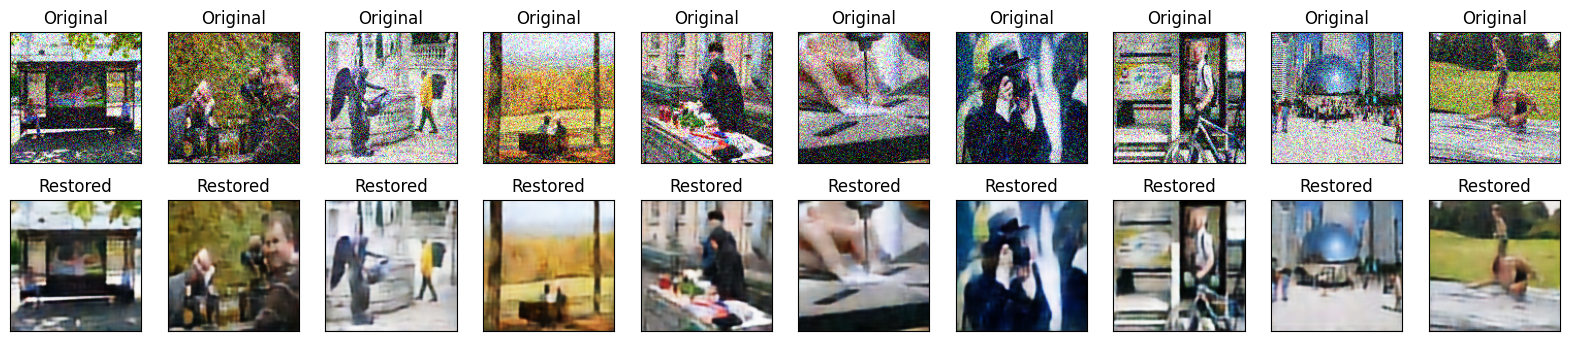

In [22]:

# Display some sample results
import matplotlib.pyplot as plt
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i+1200])
    plt.title("Original")
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display restored images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(restored_imgs[i+1200])
    plt.title("Restored")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)     
plt.show()

In [90]:
#Test a New Image
img = keras.utils.load_img("myDad.jpg.png", target_size=(128, 128)) #
x = np.array(img)
x = x.astype('float32')/255.0
noise_factor = 0.2
x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)  
x_noisy = np.clip(x_noisy, 0., 1.)
x_noisy = np.expand_dims(x_noisy, axis=0)
x = np.expand_dims(x, axis=0)

In [91]:
restored_imgs2 = autoencoder.restore(x_noisy.reshape(1,128, 128,3))

1/1 [==============================] - 0s 54ms/step


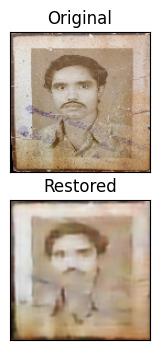

In [92]:
# Display some sample results
import matplotlib.pyplot as plt
n = 1  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x.reshape(128, 128,3))
    plt.title("Original")
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display restored images
    ax = plt.subplot(2, n,  i + 2)
    plt.imshow(restored_imgs2[i])
    plt.title("Restored")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)     
plt.show()